In [61]:
import pandas as pd
import numpy as np
import os
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)
WINDOW = 24

In [62]:
path = f'../../data/TUMTUMTUM/DF_Combined_2025_1h.csv'
df = pd.read_csv(path)
df = df[[col for col in df.columns if not col.startswith('RAYUSDT')]]
df['open_time'] = pd.to_datetime(df['open_time'])
df['open_time'] = pd.to_datetime(df['open_time']).dt.tz_localize(None)
print(f'DF shape - {df.shape}')


def get_coins(df: pd.DataFrame) -> list:
    cols = df.columns.tolist()
    coins = []
    for col in cols:
        if col.endswith('_open'):
            coin = col[:-5]
            coins.append(coin)
    return coins

DF shape - (6949, 247)


In [63]:
def add_volume_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    For each coin (detected via get_coins), compute an RSI over 'volume delta':
      vol_delta = sign(close - open) * volume
    Uses Wilder smoothing (EWMA with com=window-1).
    Outputs column: {coin}_VRSI{window}
    """
    out = df.copy()
    coins = get_coins(out)  # assumes your helper returns symbols like 'BTCUSDT', 'JUPUSDT', etc.

    for c in coins:
        vol_col   = f"{c}_volume"
        open_col  = f"{c}_open"
        close_col = f"{c}_close"

        vol = out[vol_col].astype(float)
        direction = np.sign(out[close_col].astype(float) - out[open_col].astype(float))

        vol_delta = vol * direction
        gain = vol_delta.clip(lower=0.0)
        loss = (-vol_delta).clip(lower=0.0)

        # Wilder smoothing: alpha = 1/window  <=>  com = window - 1
        avg_gain = gain.ewm(com=window-1, adjust=False, min_periods=window).mean()
        avg_loss = loss.ewm(com=window-1, adjust=False, min_periods=window).mean()

        rs = avg_gain / avg_loss.replace(0, np.nan)
        out[f"{c}_VRSI{window}"] = 100 - (100 / (1 + rs))

    # Drop initial NaNs from the smoothing window to match your previous behavior
    return out.dropna()


df = add_volume_rsi(df, window=20)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_VRSI20
19,0.83330,0.84090,0.82790,0.83890,1215964,0.00672,32.59955
20,0.83880,0.84950,0.83560,0.84470,1725490,0.00691,36.83774
21,0.84480,0.85350,0.84480,0.85290,1359077,0.00971,39.96751
22,0.85280,0.85520,0.84650,0.85210,1455530,-0.00094,37.85301
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,36.65813


0.08329798095167795


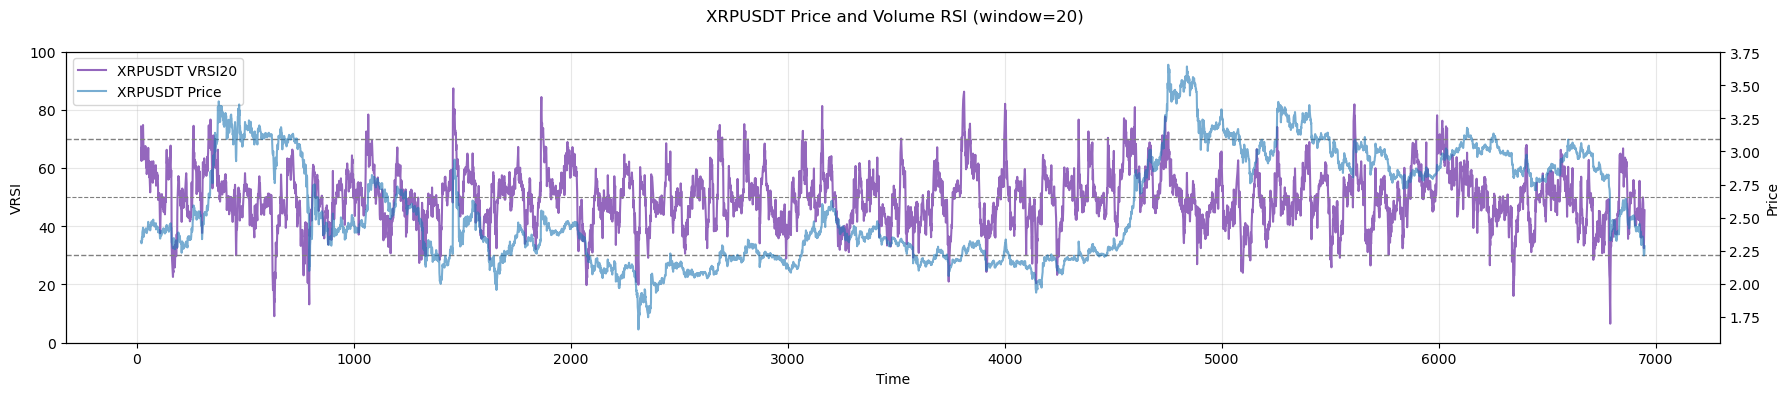

In [64]:
import matplotlib.pyplot as plt

def plot_volume_rsi(df: pd.DataFrame, coin: str, window: int = 14, figsize=(18, 4)):
    """
    Plot {coin}_VRSI{window} (Volume RSI) with 70/50/30 reference lines,
    and overlay {coin}_close price on a secondary y-axis.
    """
    v_col = f"{coin}_VRSI{window}"
    p_col = f"{coin}_close"

    if v_col not in df.columns:
        print(f"Missing column: {v_col}. Compute it first (e.g., add_volume_rsi(..., window={window})).")
        return
    if p_col not in df.columns:
        print(f"Missing column: {p_col}.")
        return

    v = df[v_col].astype(float)
    p = df[p_col].astype(float)

    print(v.corr(p))

    fig, ax1 = plt.subplots(figsize=figsize)

    # --- VRSI plot ---
    ax1.plot(df.index, v, color='tab:purple', label=f'{coin} VRSI{window}')
    ax1.axhline(70, linestyle='--', linewidth=1, color='gray')
    ax1.axhline(50, linestyle='--', linewidth=0.8, color='gray')
    ax1.axhline(30, linestyle='--', linewidth=1, color='gray')
    ax1.set_ylim(0, 100)
    ax1.set_ylabel("VRSI")
    ax1.set_xlabel("Time")

    # --- Price plot (secondary axis) ---
    ax2 = ax1.twinx()
    ax2.plot(df.index, p, color='tab:blue', alpha=0.6, label=f'{coin} Price')
    ax2.set_ylabel("Price")

    # --- Title and grid ---
    fig.suptitle(f"{coin} Price and Volume RSI (window={window})")
    ax1.grid(True, alpha=0.3)

    # --- Legends ---
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

    plt.tight_layout()
    plt.show()



plot_volume_rsi(df, 'XRPUSDT', window=20)

In [65]:
def add_is_high_volume_rsi(
    df: pd.DataFrame,
    window: int = 20,
    thresh: float = 60.0
) -> pd.DataFrame:
    """
    For each {coin}_VRSI{window}, create:
      - {coin}_IsHighVRSI{window} = VRSI >= thresh
    """
    out = df.copy()
    vrsi_cols = [c for c in out.columns if c.endswith(f"_VRSI{window}")]
    if not vrsi_cols:
        raise ValueError(f"No *_VRSI{window} columns found. Compute VRSI first.")

    for c in vrsi_cols:
        flag_col = c.replace(f"_VRSI{window}", f"_IsHighVRSI{window}")
        out[flag_col] = out[c].astype(float) >= thresh

    return out

df = add_is_high_volume_rsi(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_VRSI20,JUPUSDT_IsHighVRSI20
19,0.83330,0.84090,0.82790,0.83890,1215964,0.00672,32.59955,False
20,0.83880,0.84950,0.83560,0.84470,1725490,0.00691,36.83774,False
21,0.84480,0.85350,0.84480,0.85290,1359077,0.00971,39.96751,False
22,0.85280,0.85520,0.84650,0.85210,1455530,-0.00094,37.85301,False
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,36.65813,False


In [66]:
import pandas as pd

def add_in_position(df: pd.DataFrame, window: int = 20, shift: int = 1) -> pd.DataFrame:
    """
    Add *_InPosition = yesterday's (IsHighVRSI{window}).
    """
    flag_cols = [c for c in df.columns if c.endswith(f"_IsHighVRSI{window}")]
    if not flag_cols:
        raise ValueError(f"No *_IsHighVRSI{window} columns found. Run add_is_high_volume_rsi first.")

    in_pos = df[flag_cols].shift(shift)
    in_pos.columns = [c.replace(f"_IsHighVRSI{window}", "_InPosition") for c in flag_cols]
    in_pos = in_pos.where(pd.notna(in_pos), False)

    return pd.concat([df, in_pos], axis=1)

df = add_in_position(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_VRSI20,JUPUSDT_IsHighVRSI20,JUPUSDT_InPosition
19,0.83330,0.84090,0.82790,0.83890,1215964,0.00672,32.59955,False,False
20,0.83880,0.84950,0.83560,0.84470,1725490,0.00691,36.83774,False,False
21,0.84480,0.85350,0.84480,0.85290,1359077,0.00971,39.96751,False,False
22,0.85280,0.85520,0.84650,0.85210,1455530,-0.00094,37.85301,False,False
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,36.65813,False,False


In [67]:
def add_entry_exit_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add both *_Entry and *_Exit columns:
      - Entry = 1 when prev bar was out (False) and current bar is in (True)
      - Exit  = 1 when prev bar was in (True) and current bar is out (False)
    """
    for col in df.columns:
        if col.endswith('_Entry'):
            print('Entry columns already exists.')
            return df
        
    out = df.copy()
    inpos_cols = [c for c in out.columns if c.endswith('_InPosition')]

    prev = out[inpos_cols].astype('boolean').shift(1).fillna(False)
    curr = out[inpos_cols].astype('boolean').fillna(False)

    # Entries: transition from 0 → 1
    entries = (~prev & curr).astype('int8')
    entries.columns = [c.replace('_InPosition', '_Entry') for c in inpos_cols]

    # Exits: transition from 1 → 0
    exits = (prev & ~curr).astype('int8')
    exits.columns = [c.replace('_InPosition', '_Exit') for c in inpos_cols]

    return pd.concat([out, entries, exits], axis=1)

df = add_entry_exit_flags(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_VRSI20,JUPUSDT_IsHighVRSI20,JUPUSDT_InPosition,JUPUSDT_Entry,JUPUSDT_Exit
19,0.83330,0.84090,0.82790,0.83890,1215964,0.00672,32.59955,False,False,0,0
20,0.83880,0.84950,0.83560,0.84470,1725490,0.00691,36.83774,False,False,0,0
21,0.84480,0.85350,0.84480,0.85290,1359077,0.00971,39.96751,False,False,0,0
22,0.85280,0.85520,0.84650,0.85210,1455530,-0.00094,37.85301,False,False,0,0
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,36.65813,False,False,0,0


In [68]:
def add_ret_in_out_position(df: pd.DataFrame, fill_value=0) -> pd.DataFrame:
    """
    For each <COIN>_RET and matching <COIN>_InPosition:
      - <COIN>_RET_InPosition     = RET when InPosition True, else fill_value
      - <COIN>_RET_OutOfPosition  = RET when InPosition False, else fill_value
    """
    ret_cols = [c for c in df.columns if c.endswith('_RET')]
    newcols = {}
    idx = df.index

    for ret_col in ret_cols:
        base = ret_col[:-4]  # strip '_RET'
        pos_col = f"{base}_InPosition"
        if pos_col not in df.columns:
            continue

        # robust boolean mask: NaN -> False
        mask = df[pos_col].astype('boolean').fillna(False).to_numpy(dtype=bool)

        s = df[ret_col]
        newcols[f"{base}_RET_InPosition"]    = s.where(mask, fill_value)
        newcols[f"{base}_RET_OutOfPosition"] = s.where(~mask, fill_value)

    return df.join(pd.DataFrame(newcols, index=idx))


df = add_ret_in_out_position(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_VRSI20,JUPUSDT_IsHighVRSI20,JUPUSDT_InPosition,JUPUSDT_Entry,JUPUSDT_Exit,JUPUSDT_RET_InPosition,JUPUSDT_RET_OutOfPosition
19,0.83330,0.84090,0.82790,0.83890,1215964,0.00672,32.59955,False,False,0,0,0.00000,0.00672
20,0.83880,0.84950,0.83560,0.84470,1725490,0.00691,36.83774,False,False,0,0,0.00000,0.00691
21,0.84480,0.85350,0.84480,0.85290,1359077,0.00971,39.96751,False,False,0,0,0.00000,0.00971
22,0.85280,0.85520,0.84650,0.85210,1455530,-0.00094,37.85301,False,False,0,0,0.00000,-0.00094
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,36.65813,False,False,0,0,0.00000,-0.00106


In [69]:
def add_all_cumulative_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds cumulative return columns for each coin:
      - <COIN>_RET_CUM
      - <COIN>_RET_InPosition_CUM   (if exists)
      - <COIN>_RET_OutOfPosition_CUM (if exists)
    """
    ret_cols = [
        c for c in df.columns
        if c.endswith('_RET') and not c.endswith(('RET_InPosition', 'RET_OutOfPosition'))
    ]

    newcols = {}
    idx = df.index

    for ret_col in ret_cols:
        base = ret_col.replace('_RET', '')

        # total
        arr = (1 + df[ret_col].fillna(0)).to_numpy()
        newcols[f"{base}_RET_CUM"] = pd.Series(np.cumprod(arr) - 1, index=idx)

        # in / out (if present)
        in_col  = f"{base}_RET_InPosition"
        out_col = f"{base}_RET_OutOfPosition"

        if in_col in df.columns:
            arr_in = (1 + df[in_col].fillna(0)).to_numpy()
            newcols[f"{in_col}_CUM"] = pd.Series(np.cumprod(arr_in) - 1, index=idx)

        if out_col in df.columns:
            arr_out = (1 + df[out_col].fillna(0)).to_numpy()
            newcols[f"{out_col}_CUM"] = pd.Series(np.cumprod(arr_out) - 1, index=idx)

    # one join to avoid fragmentation
    return df.join(pd.DataFrame(newcols, index=idx))


df = add_all_cumulative_returns(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()


,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_VRSI20,JUPUSDT_IsHighVRSI20,JUPUSDT_InPosition,JUPUSDT_Entry,JUPUSDT_Exit,JUPUSDT_RET_InPosition,JUPUSDT_RET_OutOfPosition,JUPUSDT_RET_CUM,JUPUSDT_RET_InPosition_CUM,JUPUSDT_RET_OutOfPosition_CUM
19,0.83330,0.84090,0.82790,0.83890,1215964,0.00672,32.59955,False,False,0,0,0.00000,0.00672,0.00672,0.00000,0.00672
20,0.83880,0.84950,0.83560,0.84470,1725490,0.00691,36.83774,False,False,0,0,0.00000,0.00691,0.01368,0.00000,0.01368
21,0.84480,0.85350,0.84480,0.85290,1359077,0.00971,39.96751,False,False,0,0,0.00000,0.00971,0.02352,0.00000,0.02352
22,0.85280,0.85520,0.84650,0.85210,1455530,-0.00094,37.85301,False,False,0,0,0.00000,-0.00094,0.02256,0.00000,0.02256
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,36.65813,False,False,0,0,0.00000,-0.00106,0.02148,0.00000,0.02148


In [70]:
df[[col for col in df.columns if col.endswith('_Entry')]].apply(sum)

BTCUSDT_Entry       203
ICPUSDT_Entry       124
WLDUSDT_Entry       163
PENGUUSDT_Entry     167
DOTUSDT_Entry       173
TAOUSDT_Entry       158
XLMUSDT_Entry       177
ONDOUSDT_Entry      178
ENSUSDT_Entry       170
AAVEUSDT_Entry      165
RENDERUSDT_Entry    211
APTUSDT_Entry       168
HBARUSDT_Entry      141
LINKUSDT_Entry      164
FETUSDT_Entry       150
NEARUSDT_Entry      197
DOGEUSDT_Entry      174
JUPUSDT_Entry       199
SOLUSDT_Entry       201
BNBUSDT_Entry       240
SEIUSDT_Entry       171
ETHUSDT_Entry       178
UNIUSDT_Entry       188
XRPUSDT_Entry       172
ALGOUSDT_Entry      167
BCHUSDT_Entry       201
TRXUSDT_Entry       195
FILUSDT_Entry       142
TONUSDT_Entry       184
AVAXUSDT_Entry      198
ENAUSDT_Entry       160
ETCUSDT_Entry       196
ADAUSDT_Entry       167
POLUSDT_Entry       155
OPUSDT_Entry        172
ATOMUSDT_Entry      176
VETUSDT_Entry       148
SUIUSDT_Entry       164
ZECUSDT_Entry       193
LTCUSDT_Entry       183
ARBUSDT_Entry       170
dtype: int64

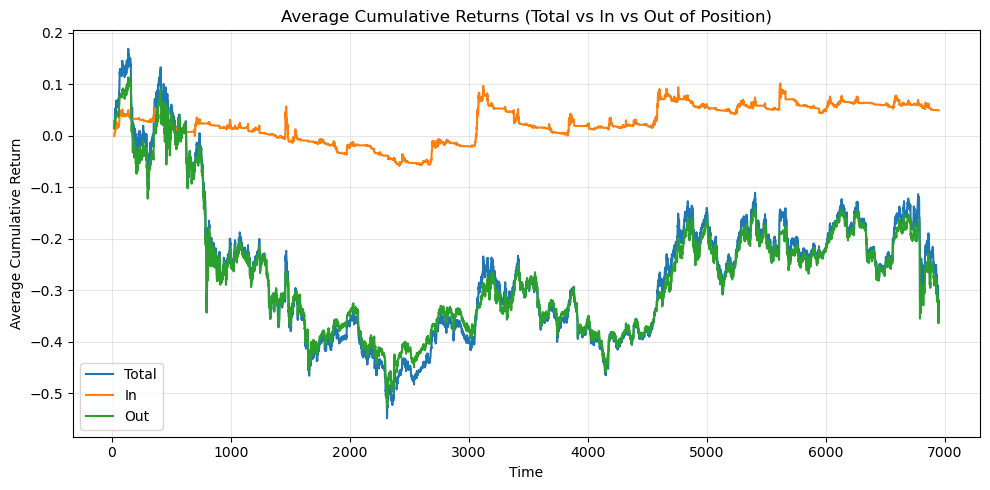

In [71]:
def plot_avg_cumulative_returns_all(df: pd.DataFrame):
    """
    Plot average cumulative returns for:
      - total  → *_RET_CUM
      - in      → *_RET_InPosition_CUM
      - out     → *_RET_OutOfPosition_CUM
    All on the same figure.
    """
    modes = {
        "total": [c for c in df.columns if c.endswith('_RET_CUM') and 'InPosition' not in c and 'OutOfPosition' not in c],
        "in":    [c for c in df.columns if c.endswith('_RET_InPosition_CUM')],
        "out":   [c for c in df.columns if c.endswith('_RET_OutOfPosition_CUM')],
    }

    plt.figure(figsize=(10, 5))

    for mode, cols in modes.items():
        if not cols:
            continue

        avg_cum = df[cols].mean(axis=1)
        plt.plot(df.index, avg_cum, label=mode.capitalize())

    plt.title("Average Cumulative Returns (Total vs In vs Out of Position)")
    plt.xlabel("Time")
    plt.ylabel("Average Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_avg_cumulative_returns_all(df)

